## Dependencias

In [1]:
import ifcopenshell
from rdflib import Graph, Namespace, URIRef, Literal, RDF, OWL, RDFS
from py2neo import Graph as Neo4jGraph, Node, Relationship
import re

## CONFIGURAÇÕES

In [ ]:
IFC_FILE = "../data/Building-Architecture.ifc"

## Conectando ao banco de dados

In [3]:
graph_db = Neo4jGraph(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

## Carregando modelo ifc

In [4]:
model = ifcopenshell.open(IFC_FILE)

In [5]:
produtos = model.by_type("IfcProduct")

In [6]:
# Explorando os produtos e entendendo suas relações
produtos

[#172=IfcBuildingElementProxy('1wADrO19H3w980h1wUyXLk',#1,'Group#18',$,$,#175,$,'454425.1027891.979946.932083.920029.919427.2037909',$),
 #302=IfcBuildingElementProxy('0bo7_K6az7AA$4RxkSNVNM',#1,'Group#19',$,$,#303,$,'454425.1027891.979946.932083.2037918',$),
 #417=IfcBuildingElementProxy('2F44QMqSH3TOkM$SZoqCBe',#1,'origin','The local position for coordination of aspect models.','origin',#423,#433,'454425.1027891.1032757',$),
 #436=IfcBuildingElementProxy('3Fit2Fad92zf2f6aWdJtF5',#1,'geo-reference','The reference point for transforming the local engineering coordinate system into the coordinate reference system of the underlying map.','origin',#442,#452,'454425.1032696',$),
 #296=IfcChimney('3dkFAzOGrAIuOzY_RdrdVv',#1,'house - chimney','A chimney, standing tall and proud, guiding smoke away from the home.','flue',#297,$,'454425.1027891.979946.932083.2023772',$),
 #399=IfcEarthworksFill('3_4VN63S96DfWiJjgG8j1C',#1,'sand bedding','A layer of ground floor sand bedding, providing a stable

## CRIAR GRAFO RDF COM DADOS BÁSICOS

In [7]:

ns = Namespace("http://example.org/ifc/") # Define a namespace for RDF que é usado para identificar os recursos IFC
rdf_graph = Graph()

## Populando o grafo com dados do modelo ifc

In [8]:
for element in produtos:
    if not element.GlobalId:
        continue

    uri = URIRef(ns[element.GlobalId])
    rdf_graph.add((uri, RDF.type, URIRef(ns[element.is_a()])))
    if element.Name:
        rdf_graph.add((uri, ns["name"], Literal(element.Name)))

print(f"📊 Grafo RDF gerado com {len(rdf_graph)} triplas.")

📊 Grafo RDF gerado com 44 triplas.


## Explorando o grafo

In [9]:
rdf_graph

<Graph identifier=N4badc774156d40fb900f59474db5afbc (<class 'rdflib.graph.Graph'>)>

In [10]:
rdf_graph.qname(URIRef(ns["name"]))

'ns1:name'

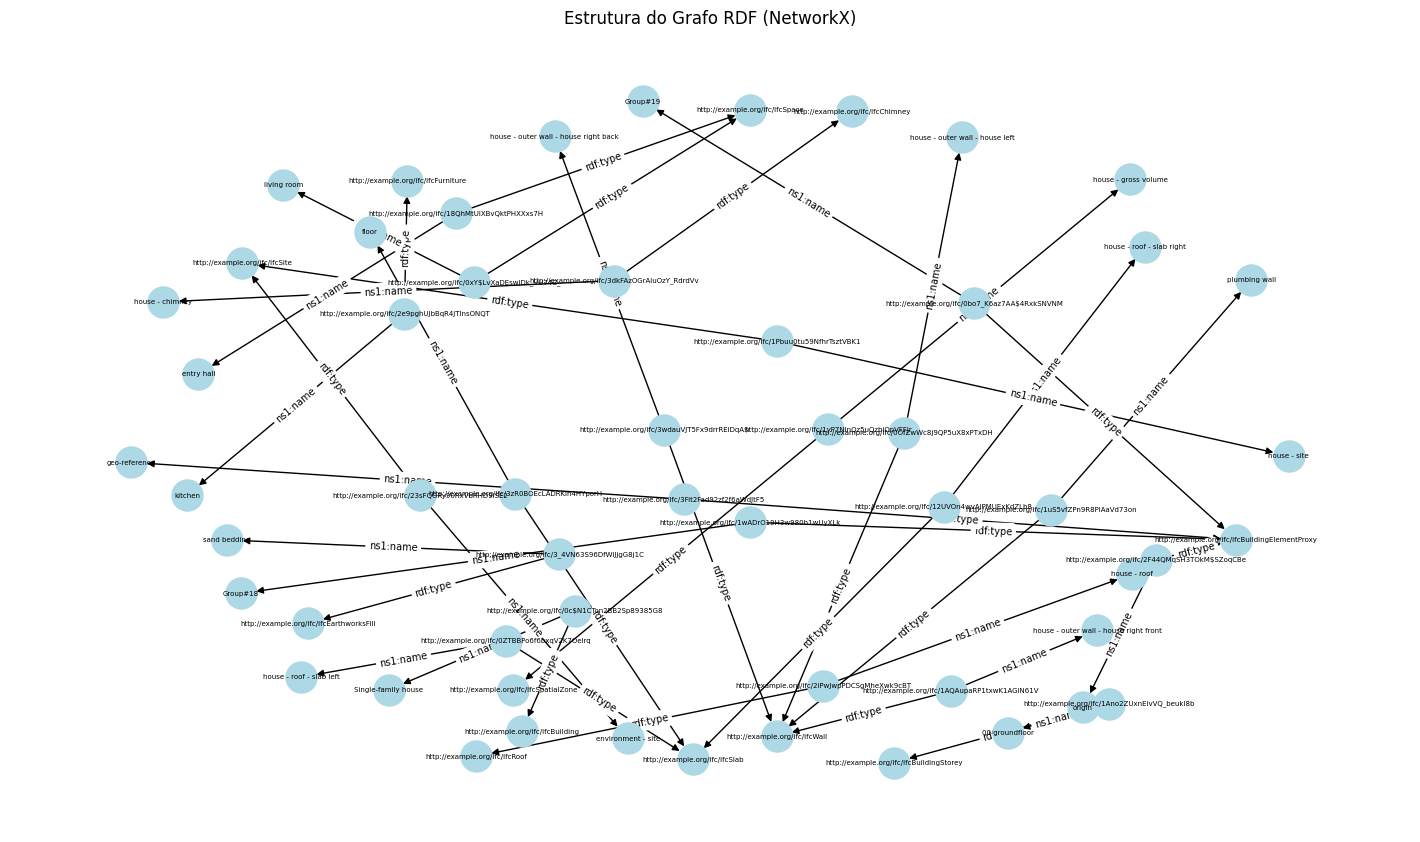

In [11]:
import networkx as nx

import matplotlib.pyplot as plt

# Converter o grafo RDF para um grafo NetworkX
G = nx.DiGraph()
for s, p, o in rdf_graph:
    G.add_edge(str(s), str(o), label=rdf_graph.qname(p))

plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=5, arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title("Estrutura do Grafo RDF (NetworkX)")
plt.show()

## Transformando esstrutura do grafo em uma ontologia
### Criando a ontologia

In [12]:
onto = Graph()
onto.parse("../data/ifc-ontology.ttl", format="turtle")

IFC_ONT = Namespace("http://example.org/ifc/ontology#")
RDFS = Namespace("http://www.w3.org/2000/01/rdf-schema#")

for element in produtos:
    element_class = element.is_a()
    rdf_graph.add((uri, RDF.type, URIRef(IFC_ONT[element_class])))
    
    # Herança: IfcWall → IfcBuildingElement
    superclass = onto.value(IFC_ONT[element_class], RDFS.subClassOf, None)
    if superclass:
        rdf_graph.add((uri, RDF.type, superclass))
    
    if element.Decomposes:  # Relação de decomposição do IFC
        parent_uri = URIRef(ns[element.Decomposes[0].GlobalId])
        rdf_graph.add((uri, IFC_ONT.isPartOf, parent_uri))

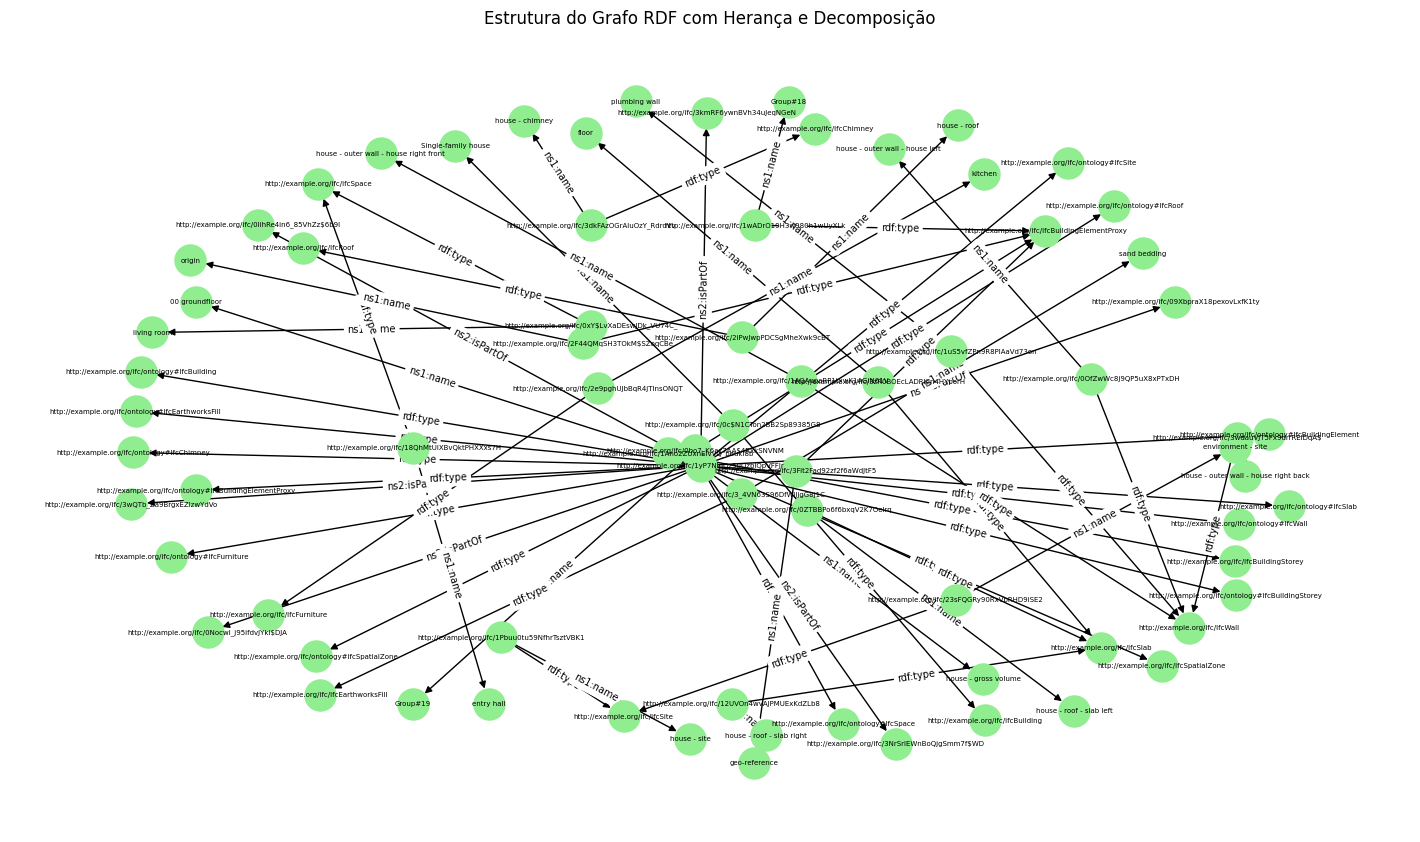

In [13]:
# Plotando o grafo RDF atualizado
G = nx.DiGraph()
for s, p, o in rdf_graph:
    G.add_edge(str(s), str(o), label=rdf_graph.qname(p))
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightgreen", font_size=5, arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title("Estrutura do Grafo RDF com Herança e Decomposição")
plt.show()

In [14]:
# carregando o graf atualizado RDF no Neo4j
def load_rdf_to_neo4j(rdf_graph, neo4j_graph):
    for s, p, o in rdf_graph:
        subject = str(s)
        object_ = str(o)
        
        # Criar ou obter o nó do sujeito
        subject_node = Node("Resource", uri=subject)
        neo4j_graph.merge(subject_node, "Resource", "uri")
        
        # Criar ou obter o nó do objeto
        object_node = Node("Resource", uri=object_)
        neo4j_graph.merge(object_node, "Resource", "uri")
        
        # Criar a relação entre sujeito e objeto
        relationship_type = rdf_graph.qname(p)
        rel = Relationship(subject_node, relationship_type, object_node)
        neo4j_graph.merge(rel)
    

In [15]:
load_rdf_to_neo4j(rdf_graph, graph_db)

In [20]:
# verificando os nós e relações no Neo4j
def print_neo4j_graph(graph):
    query = "MATCH (n)-[r]->(m) RETURN n, r, m LIMIT 100"
    results = graph.run(query)
    return [(record["n"]["uri"], record["r"].type, record["m"]["uri"]) for record in results]

In [21]:
print_neo4j_graph(graph_db)

[('http://example.org/ifc/1Pbuu0tu59NfhrTsztVBK1',
  <function py2neo.data.Relationship.type(name)>,
  'house - site'),
 ('http://example.org/ifc/1Pbuu0tu59NfhrTsztVBK1',
  <function py2neo.data.Relationship.type(name)>,
  'http://example.org/ifc/IfcSite'),
 ('http://example.org/ifc/1yP7NInQz5uQzbiOpVFFJr',
  <function py2neo.data.Relationship.type(name)>,
  'house - gross volume'),
 ('http://example.org/ifc/1yP7NInQz5uQzbiOpVFFJr',
  <function py2neo.data.Relationship.type(name)>,
  'http://example.org/ifc/IfcSpatialZone'),
 ('http://example.org/ifc/1yP7NInQz5uQzbiOpVFFJr',
  <function py2neo.data.Relationship.type(name)>,
  'http://example.org/ifc/ontology#IfcSpatialZone'),
 ('http://example.org/ifc/1yP7NInQz5uQzbiOpVFFJr',
  <function py2neo.data.Relationship.type(name)>,
  'http://example.org/ifc/ontology#IfcSpace'),
 ('http://example.org/ifc/1yP7NInQz5uQzbiOpVFFJr',
  <function py2neo.data.Relationship.type(name)>,
  'http://example.org/ifc/ontology#IfcEarthworksFill'),
 ('http://

In [27]:
# Inferindo novas relações no Neo4j
def infer_relations(graph):
    query = """
    MATCH (a:Resource)-[r:subClassOf]->(b:Resource)
    WITH a, b
    MATCH (c:Resource)-[d]->(a)
    MERGE (c)-[:subClassOf]->(b)
    """
    graph.run(query)
infer_relations(graph_db)

In [28]:
print_neo4j_graph(graph_db)

[('http://example.org/ifc/1Pbuu0tu59NfhrTsztVBK1',
  <function py2neo.data.Relationship.type(name)>,
  'house - site'),
 ('http://example.org/ifc/1Pbuu0tu59NfhrTsztVBK1',
  <function py2neo.data.Relationship.type(name)>,
  'http://example.org/ifc/IfcSite'),
 ('http://example.org/ifc/1yP7NInQz5uQzbiOpVFFJr',
  <function py2neo.data.Relationship.type(name)>,
  'house - gross volume'),
 ('http://example.org/ifc/1yP7NInQz5uQzbiOpVFFJr',
  <function py2neo.data.Relationship.type(name)>,
  'http://example.org/ifc/IfcSpatialZone'),
 ('http://example.org/ifc/1yP7NInQz5uQzbiOpVFFJr',
  <function py2neo.data.Relationship.type(name)>,
  'http://example.org/ifc/ontology#IfcSpatialZone'),
 ('http://example.org/ifc/1yP7NInQz5uQzbiOpVFFJr',
  <function py2neo.data.Relationship.type(name)>,
  'http://example.org/ifc/ontology#IfcSpace'),
 ('http://example.org/ifc/1yP7NInQz5uQzbiOpVFFJr',
  <function py2neo.data.Relationship.type(name)>,
  'http://example.org/ifc/ontology#IfcEarthworksFill'),
 ('http://

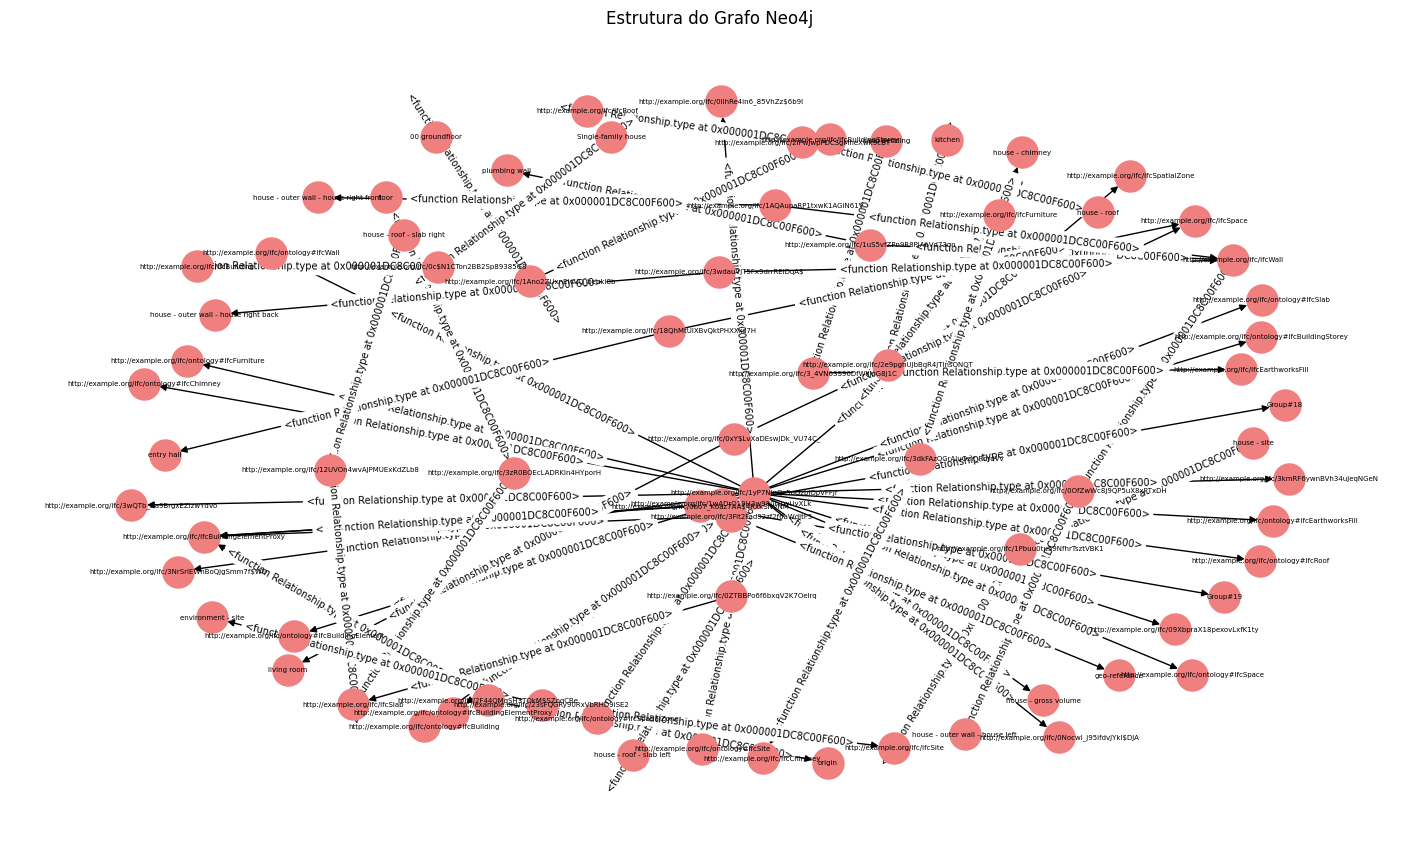

In [29]:
# plotando o grafo Neo4j
def plot_neo4j_graph(graph):
    query = "MATCH (n)-[r]->(m) RETURN n, r, m LIMIT 100"
    results = graph.run(query)
    
    G = nx.DiGraph()
    for record in results:
        subject = str(record["n"]["uri"])
        object_ = str(record["m"]["uri"])
        relationship_type = record["r"].type
        G.add_edge(subject, object_, label=relationship_type)
    
    plt.figure(figsize=(14, 8))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightcoral", font_size=5, arrows=True)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.title("Estrutura do Grafo Neo4j")
    plt.show()

plot_neo4j_graph(graph_db)